# [NEW] 카메라 스티커앱 만들기

## 루브릭
1. 원본 이미지에 스티커 사진을 합성하기
2. 좌표 계산을 통해 스티커 이미지가 얼굴에 잘 어울리도록 출력하기
3. 다양한 원본 이미지에 적용해보고, 나타나는 문제점에 대해 분석하기
    - 얼굴각도, 이미지 밝기, 촬영거리 등 변수에 따른 영향도

이미지 처리를 위한 라이브러리 설치(optional)

In [1]:
# pip install opencv-python
# pip install cmake
# pip install dlib

In [2]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import dlib

## 데이터 준비
* open-cv 라이브러리를 사용하여 원본 이미지를 불러온다
    - **이미지의 컬러 채널 순서가 다른것에 유의하기** : cv2.COLOR_BGR2RGB

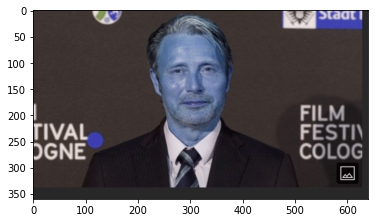

In [3]:
import os
my_image_path = os.getenv("HOME") + "/aiffel/camera_sticker/images/image.png"
img_bgr = cv2.imread(my_image_path)

# 이미지의 비율에 따라 구분하여 리사이즈
if img_bgr.shape[0] < img_bgr.shape[1]:
    img_bgr = cv2.resize(img_bgr, (640,360))
elif img_bgr.shape[0] > img_bgr.shape[1]:
    img_bgr = cv2.resize(img_bgr, (360,640))
else:
    img_bgr = cv2.resize(img_bgr, (500,500))
    
img_show = img_bgr.copy()
plt.imshow(img_bgr)
plt.show()

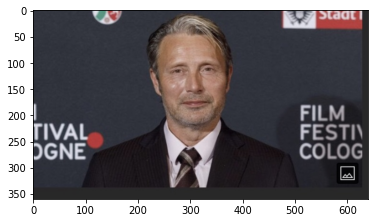

In [4]:
img_rgb = cv2.cvtColor(img_bgr,cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

### 얼굴 위치 검출을 위한 `dlib` 사용하기

In [5]:
detector_hog = dlib.get_frontal_face_detector()

In [6]:
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
dlib_rects = detector_hog(img_rgb, 1)

* 얼굴의 대략적인 위치를 검출하기 위해서 `dlib`의 `frontal_face_detector`를 사용함

* Two point bbox 형태의 얼굴 검출 결과를 dlib_rects에 담고 이미지 위에 표시한다

rectangles[[(239, 82) (368, 211)]]


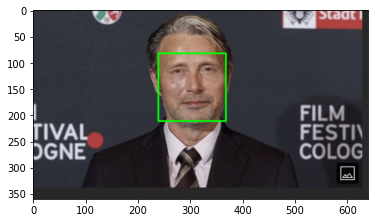

In [7]:
print(dlib_rects)

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()
    
    cv2.rectangle(img_show, (l,t),(r,b), (0,255,0), 2, lineType=cv2.LINE_AA)
    
img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)    
plt.imshow(img_show_rgb)
plt.show()

* 사람 얼굴 키포인트(landmark 로 표기) 검출을 위해서 `dlib.shape_predictor` 모델을 로드함

In [8]:
model_path = os.getenv("HOME") + '/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)

In [9]:
list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)
    
print(len(list_landmarks[0]))

68


68 개의 랜드마크를 검출한 것으로 보인다\
랜드마크의 위치들을 원본 이미지 위에 표시해보자

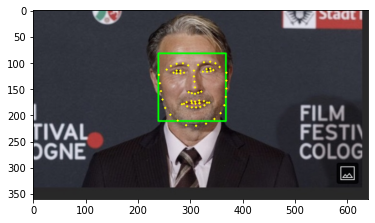

In [10]:
for landmark in list_landmarks:
    for point in landmark:
        cv2.circle(img_show, point, 2, (0,255,255), -1)
        
img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)    
plt.imshow(img_show_rgb)
plt.show()

## 이미지 합성
### 콧수염 합성 위치 선정하기
코의 정중앙부분 랜드마크 33을 기준으로 x,y 위치를 잡고,
다른 랜드마크(2번, 30번 등)을 활용하여 이미지가 들어갈 범위의 가로 세로 길이를 적당하게 맞춘다

In [11]:
# index 2, 30, 33

for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print(landmark[33])  # nose center index 30
    x = landmark[33][0]
    y = landmark[33][1] + 7
    w = int((landmark[14][0] - landmark[2][0]) / 2)
    h = int((landmark[33][1] - landmark[30][1]) * 2)
    print('(x,y): (%d,%d)'%(x,y))
    print('(w,h): (%d,%d)'%(w,h))

(309, 159)
(x,y): (309,166)
(w,h): (62,24)


(24, 62, 3)


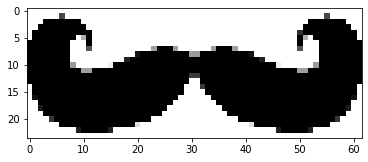

In [12]:
import os
sticker_path = os.getenv("HOME") + '/aiffel/camera_sticker/images/mustache.png'
img_sticker = cv2.imread(sticker_path)
img_sticker = img_sticker[180:330]
img_sticker = cv2.resize(img_sticker, (w,h))
print(img_sticker.shape)
plt.imshow(img_sticker)

In [13]:
sticker_area = img_show[int(y-h/2):int(y+h/2), int(x-w/2):int(x+w/2)]
img_show[int(y-h/2):int(y+h/2), int(x-w/2):int(x+w/2)] = \
    np.where(img_sticker==0, img_sticker, sticker_area).astype(np.uint8)

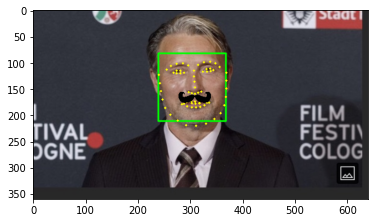

In [14]:
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

위치 결과를 제거하여 합성 이미지만 남기고 출력한다
(오늘도 멋있으신 미켈슨 형님...)

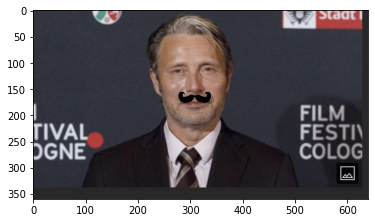

In [15]:
sticker_area = img_bgr[int(y-h/2):int(y+h/2), int(x-w/2):int(x+w/2)]
img_bgr[int(y-h/2):int(y+h/2), int(x-w/2):int(x+w/2)] = \
    np.where(img_sticker==0,img_sticker, sticker_area).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

## 입력 이미지에 변수 적용하기
얼굴 각도, 피사체 크기, 이미지 밝기

### 반복 사용을 위한 함수화
함수화 : 입력(파일명), 출력 합성 이미지

In [16]:
def mustache(image_path):
    img_bgr = cv2.imread(image_path)

    # 이미지의 비율에 따라 다르게 리사이즈
    if img_bgr.shape[0] < img_bgr.shape[1]:
        img_bgr = cv2.resize(img_bgr, (640,360))
    elif img_bgr.shape[0] > img_bgr.shape[1]:
        img_bgr = cv2.resize(img_bgr, (360,640))
    else:
        img_bgr = cv2.resize(img_bgr, (500,500))

    img_show = img_bgr.copy()

    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    dlib_rects = detector_hog(img_rgb, 1)

    list_landmarks = []
    for dlib_rect in dlib_rects:
        points = landmark_predictor(img_rgb, dlib_rect)
        list_points = list(map(lambda p: (p.x, p.y), points.parts()))
        list_landmarks.append(list_points)

    for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
        x = landmark[33][0]
        y = landmark[33][1] + 7
        w = int((landmark[14][0] - landmark[2][0]) / 2)
        h = int((landmark[33][1] - landmark[30][1]) * 2)

    sticker_path = os.getenv("HOME") + '/aiffel/camera_sticker/images/mustache.png'
    img_sticker = cv2.imread(sticker_path)
    img_sticker = img_sticker[180:330]
    img_sticker = cv2.resize(img_sticker, (w,h))

    sticker_area = img_bgr[int(y-h/2):int(y+h/2), int(x-w/2):int(x+w/2)]
    img_bgr[int(y-h/2):int(y+h/2), int(x-w/2):int(x+w/2)] = \
        np.where(img_sticker==0,img_sticker, sticker_area).astype(np.uint8)
    return img_bgr

### 동양인 얼굴과 피부톤 변화
사용한 검출 모델이 동양인의 이목구비와 형상에도 적용할 수 있는지 여부를 확인하기 위하여, 나의 셀카 _(...부끄럽도다)_ 를 적용했다. 피부톤도 이전 샘플보다 뽀샤시하게 편집이 들어가 있는데도 충분히 적용가능한 성능을 보여준다.\
조명이 얼굴에 그림자를 드리운 사진으로도 합성을 적용해 보았다. 자세히 관찰할 경우 수염의 시작 부분이 살짝 왼쪽으로 치우쳐있는 것을 발견할 수 있었다. 원본 이미지의 코 부분의 윤곽이 명확하지 않아 나타나는 차이로 보인다. 

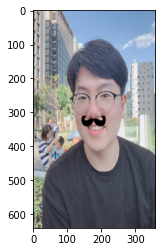

In [17]:
my_image_path = os.getenv("HOME") + "/aiffel/camera_sticker/images/image3.png"
img_bgr = mustache(my_image_path)
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

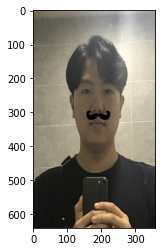

In [18]:
my_image_path = os.getenv("HOME") + "/aiffel/camera_sticker/images/image4.png"
img_bgr = mustache(my_image_path)
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

### 카메라와 마주보는 얼굴의 각도
이전 사진들과 다르게 가까이 촬영한 사진을 사용해 보았다. 역시 정상적으로 작동수하였다.\
랜드마크와 맞는 이목구비가 모두 포함된 사진에서는 얼굴이 어느정도 사선을 바라보고 있더라도 온전하게 합성 기능을 구현할 수 있었다.

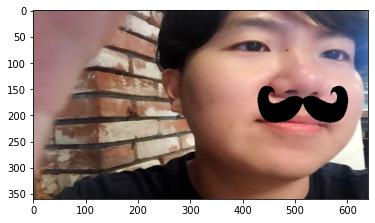

In [19]:
my_image_path = os.getenv("HOME") + "/aiffel/camera_sticker/images/image5.png"
img_bgr = mustache(my_image_path)
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

하지만 측면을 바라보는 사진에서 landmark 가 검출되지 않아 함수에서 에러가 발생하였다. 이미지에서 특정 부위가 누락되는 경우에도 작동할 수 있도록, 다양한 각도의 데이터를 포함한 모델이 필요한 것으로 보인다.\
딥러닝 모델 검출기가 아닌 경우, 케이스로 구분하는 하드코딩으로 구현할 수 있을지 의문과 함께 검출기가 작동하는 시간에서 차이가 벌어질 것으로 예상되었다.

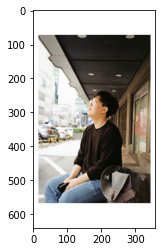

In [20]:
my_image_path = os.getenv("HOME") + "/aiffel/camera_sticker/images/image6.png"
img_bgr = cv2.imread(my_image_path)

# 이미지의 비율에 따라 구분하여 리사이즈
if img_bgr.shape[0] < img_bgr.shape[1]:
    img_bgr = cv2.resize(img_bgr, (640,360))
elif img_bgr.shape[0] > img_bgr.shape[1]:
    img_bgr = cv2.resize(img_bgr, (360,640))
else:
    img_bgr = cv2.resize(img_bgr, (500,500))

img_rgb = cv2.cvtColor(img_bgr,cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

## 회고
* 원본이미지에 원하는 `스티커 이미지를 합성`하는 기능을 구현하였다,


* 처음 이미지 합성을 시도했을 떄 위치를 정해주는 부분을 찾기 어려워 고생한 기억이 있다. 기존에 있던 노드에서는 원본 이미지 밖으로 나가는 부분을 삭제하기 위한 기능을 구현한 바 있고 이것들을 읽는 부분이 나에게 어려운 것 같았다.



* 합성될 위치만 적용된 결과물이 출력됐을 때, 다른 여러 이미지에 사용하기 어렵다는 결론이 도출됐다. 원본 이미지마다 인물의 얼굴 크기가 다를 수 있다는 문제점이 발생했고, 이를 해결하려면 `원본 이미지의 얼굴 비율에 맞게 합성할 이미지를 확대-축소할 필요가 있었다.` 결과적으로 중심이 되는 랜드마크와 다른 랜드마크 사이의 거리 비율을 계산해 이미지 크기로 적용할 수 있도록 해결하였다.



* 노트북으로 상세한 기능을 구현하고, 필요한 부분만 잘라 붙여 `함수화`를 해보았다. `입력과 출력을 맞춰주는 것`이 아주 중요하게 작용하였고, 수정 사항이 있을 떄 바로 반영하기 위해서 `인덱싱`을 잘해두는 것이 필요했다. 변수 중에 초기화가 필요한 부분이 있어 `클래스` 형태로 변경하는 것으로 개선할 필요성이 있다.(개별 셀 코드 -> 함수 -> 객체화)

* _회고라고 쓰니까 좀 쑥쓰럽다 흠._ 코드와 분석을 동시에 진행하는 노트북 형식을 본격적으로 사용해보기는 거의 처음이라, 낯설다는 느낌과 함께, 작업이 수월하다는 느낌이 있어 나쁘지않다.

